# Imports and hyperparameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# hyperparameters

SWARM_SIZE = 1000
ITERATIONS = 100

# Utils

In [4]:
# utils function

def compute_magnitude(pts):
    """Return a vector of magnitudes of an array of points in R^2"""
    return np.sqrt(np.power(pts[:, 0], 2) + np.power(pts[:, 1], 2))   

def compute_center_mass(pts):
    """Return the center of mass of points in R^2"""
    return np.array([pts.mean(axis=0)])

def compute_dispersion(pts, center_mass):
    """Return the dispersion of the points as the average distance from the center of mass"""
    return compute_magnitude(pts - center_mass).mean()

# Fitness functions

**Modifications of fitness functions**:
- translations: to change the minima; to translate in direction $(x', y')$ give as input $(x-x', y-y')$.
- scale of the variables: to change the scale of the problem and the size of the convex regions 
- combination of the two by doing $(x - x') * x_{scale}$

In [5]:
# fitness function modifier

def fitness_decorator(fit, var_translation, var_scale, amplitude, intercept):
    """var_translation and var_scale have (2,) shape"""
    def modified_fit(solutions):
        solutions = solutions - var_translation
        solutions = solutions * var_scale

        return amplitude * fit(solutions) + intercept
    
    return modified_fit

We look for functions with one global minima. They can have only one minima or multiple local minima.
Functions:
- circle
- rastrigin
- 

In [6]:
# fitness functions
def sphere(solutions):
    """
    Info:
    - global minimum = f(0, 0) = 0
    - local minima: no
    """
    x = solutions[:, 0]
    y = solutions[:, 1]
    return np.power(x, 2) + np.power(y, 2)

def rastrigin(solutions):
    """
    Info:
    - global minimum = f(0, 0) = 0
    - local minima: yes
    """
    A = 10
    x = solutions[:, 0]
    y = solutions[:, 1]
    return A*2 + (np.power(solutions, 2) - A*np.cos(solutions * 2 * np.pi)).sum(axis=1)

def eggholder(solutions):
    """
    Info:
    - global minimum = f(0, 0) = 0
    - local minima: no
    """
    x = solutions[:, 0]
    y = solutions[:, 1]
    return - (y + 47)* np.sin(np.sqrt(np.abs(x* 0.5 + (y + 47)))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))

def schaffer(solutions):
    x = solutions[:, 0]
    y = solutions[:, 1]
    return 0.5 + (np.power(
        np.sin(np.power(x, 2) - np.power(y, 2)) - 0.5, 2)
        ) / np.power(
            1 + 0.001*(np.power(x, 2) + np.power(y, 2)), 2
        )

def rosenbrock(solutions):
    """
    Info:
    - global minimum = f(a, a**2) = 0
    - local minima: boh
    """
    a = 0
    b = 100
    x = solutions[:, 0]
    y = solutions[:, 1]
    return np.power(a - x, 2)  + b * np.power((y - np.power(x, 2)), 2)

# Swarm class

In [94]:
class Swarm:
    """Class swarm that implementes PSO for 2D problems"""

    def __init__(
        self,
        n,
        fit,
        soc_factor=1.49,
        cog_factor=1.49,
        inertia_weight=0.9,
        vel_magnitude_limits=[0.01, 50],
        ):

        self.n = n # number of particles
        self.fit = fit # fitness function

        self.soc_factor = soc_factor
        self.cog_factor = cog_factor
        self.inertia_weight = inertia_weight
        self.inertia_decay = 0.99
        self.inertia_min = 0.2

        self.vel_magnitude_limits = vel_magnitude_limits # min and max velocity magnitude

        # initialize
        self.swarm = None
        self.velocity = None
        self.initialization()

        self.personal_best = self.swarm
        self.global_best = np.array([self.personal_best[np.argmin(self.fit(self.personal_best))]])
        self.center_mass = compute_center_mass(self.swarm)
        self.dispersion = compute_dispersion(self.swarm, self.center_mass) # average distance from center of mass

    def initialization(self, gen_position_limits=np.array([[-5, 5]]*2)):
        
        """Function dealing with the initialization of the particles initial positions and velocities"""

        # initialize population
        self.swarm = np.random.uniform(
            gen_position_limits[:, 0], 
            gen_position_limits[:, 1], 
            size=(self.n, 2))
        
        # initialize velocity
        self.velocity = np.zeros((self.n, 2))

    def update_velocity(self):
        # stochastic elements
        r1 = np.random.uniform(np.zeros(2), np.ones(2), size=(self.n, 2))
        r2 = np.random.uniform(np.zeros(2), np.ones(2), size=(self.n, 2))
        
        # factors
        inertia = self.velocity * self.inertia_weight
        social = self.soc_factor * r1 * (self.global_best - self.swarm)
        cognitive = self.cog_factor * r2 * (self.personal_best - self.swarm)

        # update velocity
        self.velocity = inertia + social + cognitive
        self.inertia_weight = self.inertia_weight * self.inertia_decay
        if self.inertia_weight < self.inertia_min:
            self.inertia_weight = self.inertia_min

        # check velocity lower/upper magnitude limit
        # MODIFY TO DEAL WITH ZERO VELOCITY!!!!
        magnitude = compute_magnitude(self.velocity)
        large_vel = magnitude > self.vel_magnitude_limits[1]
        small_vel = (magnitude < self.vel_magnitude_limits[0]) & (magnitude > 0)
        if large_vel.sum() > 0:
            self.velocity[large_vel] = self.velocity[large_vel] / np.array([[magnitude[large_vel]]]).reshape(large_vel.sum(), 1) * self.vel_magnitude_limits[1]
        if small_vel.sum() > 0:
            self.velocity[small_vel] = self.velocity[small_vel] / np.array([[magnitude[small_vel]]]).reshape(small_vel.sum(), 1) * self.vel_magnitude_limits[0]

    def update_position(self):
        self.swarm = self.swarm + self.velocity

        # update best
        indexes = self.fit(self.personal_best) > self.fit(self.swarm)
        self.personal_best[indexes] = self.swarm[indexes]
        self.global_best = np.array([self.personal_best[np.argmin(self.fit(self.personal_best))]])

        # update center mass
        self.center_mass = compute_center_mass(self.swarm)

        # compute dispersion
        self.dispersion = compute_dispersion(self.swarm, self.center_mass)

    def generate(self, cycles=1):

        for _ in range(cycles):
            self.update_velocity()
            self.update_position()

    def plot(self):
        plt.scatter(self.swarm[:, 0], self.swarm[:, 1], s=1, color='black')
        plt.scatter(self.center_mass[:, 0], self.center_mass[:, 1], s=16, color='red', marker='s', alpha=0.5)
        plt.scatter(self.global_best[:, 0], self.global_best[:, 1], s=16, color='green', marker='+')
    
    def describe(self):
        print(f'best fit value = {self.fit(self.global_best)[0]}')
        print(f'best solution = {self.global_best[0]}')
        print(f'center of mass = {self.center_mass[0]}')
        print(f'dispersion = {self.dispersion}')

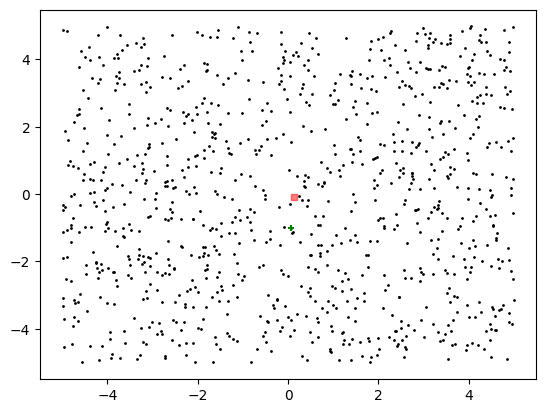

In [95]:
S = Swarm(1000, rastrigin)

S.plot()

In [ ]:
S.generate(1000)
S.describe()

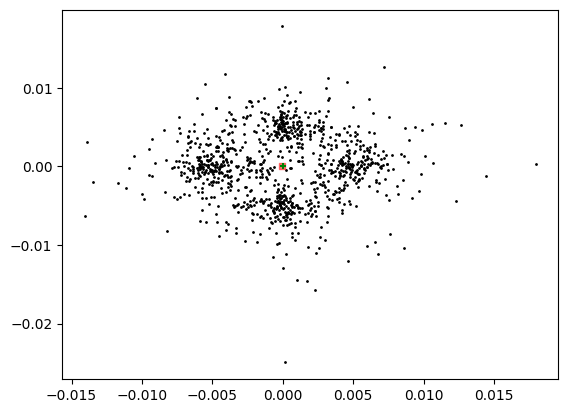

In [98]:
S.plot()